In [1]:
%%capture
%pip install qldpc
%pip install matplotlib

# Computing logical error rates

Here we show how to compute the logical error rates of error-correcting codes.  We consider both a code capacity model, in which a code accumulates errors that are corrected noiselessly, and a simulation of logical error rates in a quantum memory experiment with circuit-level noise.

### imports and common code

In [2]:
import os
from collections.abc import Sequence

import matplotlib.pyplot as plt
import numpy as np
import sinter
from sympy.abc import x, y

from qldpc import circuits, codes, decoders
from qldpc.objects import Pauli, PauliXZ

%matplotlib inline


def get_label(
    code: codes.ClassicalCode | codes.QuditCode,
    distance_trials: bool | int = False,
) -> str:
    """Get a label for a code in a figure.

    If the code distance is not known, use a given number of trials to estimate it.
    """
    known_distance = code.get_distance_if_known()
    if isinstance(known_distance, int):
        return f"$d={known_distance}$"
    if not distance_trials:
        return f"[{len(code)}, {code.dimension}]"
    distance_estimate = code.get_distance_bound(num_trials=int(distance_trials))
    return f"[{len(code)}, {code.dimension}, d <= {distance_estimate}]"

## Code capacity

In the simplest code capacity model, physical errors are sampled by flipping each bit (or depolarizing each qubit) of the code with some i.i.d. probability.  The logical error rate of the code is then the probability that a physical error is decoded incorrectly, resulting in a logical error upon correction.  For a fixed noise model, this logical error rate is a joint property of (a) the code and (b) the decoder.

Our main driver for computing logical error rates in a code capacity model is the `.get_logical_error_rate_func` method of any `ClassicalCode` or `QuditCode`.  This method randomly samples and decodes a large number of physical physical errors, and returns a function that uses simulation results to map a physical error rate to an estimated logical error rate.  Below, we use this method to produce a plot of physical vs. logical error rates for a few codes.

### simulation and plotting code

In [3]:
def make_code_capacity_figure(
    codes_to_plot: Sequence[codes.ClassicalCode | codes.QuditCode],
    error_rates: Sequence[float] = list(np.logspace(-2, -0.1, 100)),
    num_samples: int = 10**4,
    distance_trials: int = 100,
    figsize: tuple[int, int] = (5, 4),
    **decoding_kwargs: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Plot physical vs. logical error rates for the given codes in a code capacity model.

    Args:
        codes_to_plot: The codes whose error rates we want to plot.
        error_rates: The i.i.d. probabilities of physical errors on each bit/qubit.
        num_samples: The number of physical errors to sample in a simulation.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The distance (or its estimate) is used to label each code in the legend.
        figsize: The size of the figure to produce.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        The matplotlib.pyplot figure and axis.
    """
    figure, axis = plt.subplots(figsize=figsize)

    for code in codes_to_plot:
        # this is the slow part where the simulations happen
        get_logical_error_rate = code.get_logical_error_rate_func(
            num_samples, max(error_rates), **decoding_kwargs
        )

        # this part is fast
        logical_rates, stderrs = get_logical_error_rate(error_rates)

        # add these results to the figure
        label = get_label(code, distance_trials)
        line, *_ = axis.plot(error_rates, logical_rates, label=label)
        axis.fill_between(
            error_rates,
            logical_rates - stderrs,
            logical_rates + stderrs,
            color=line.get_color(),
            alpha=0.2,
        )

    # add a reference line for p_log = p_phys, and clean up the figure
    axis.axline(
        (0, 0),
        slope=1,
        color="k",
        linestyle=":",
        label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$",
    )
    axis.loglog()
    axis.set_xlim(right=1)
    axis.set_ylim(bottom=max(min(error_rates) ** 2, axis.get_ylim()[0]), top=1)
    axis.set_xlabel(r"physical error rate")
    axis.set_ylabel(r"logical error rate")
    axis.legend(loc="best")
    axis.grid(which="both")
    figure.tight_layout()

    return figure, axis

### The repetition and surface codes

These codes can be decodes with minimum-weight perfect matching (MWPM).

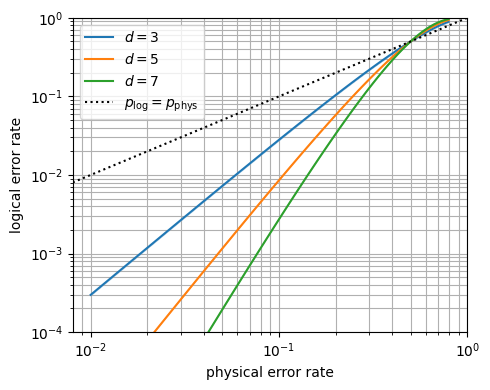

In [4]:
rep_codes = [codes.RepetitionCode(dist) for dist in [3, 5, 7]]
make_code_capacity_figure(rep_codes, with_MWPM=True)
plt.show()

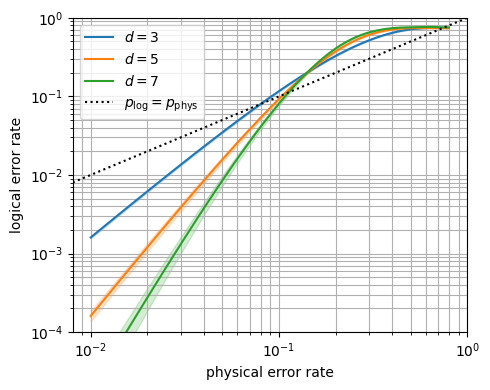

In [5]:
surface_codes = [codes.SurfaceCode(dist) for dist in [3, 5, 7]]
make_code_capacity_figure(surface_codes, with_MWPM=True)
plt.show()

### Bivariate bicycle codes

As introduced in [arXiv:2308.07915](https://arxiv.org/abs/2308.07915), these codes can be decoded with (for example) [BD-LSD](https://arxiv.org/abs/2406.18655).

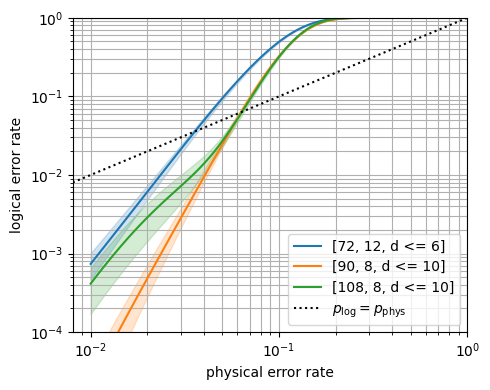

In [6]:
bb_codes = [
    codes.BBCode(
        {x: 6, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
    codes.BBCode(
        {x: 15, y: 3},
        x**9 + y + y**2,
        1 + x**2 + x**7,
    ),
    codes.BBCode(
        {x: 9, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
]
make_code_capacity_figure(bb_codes, with_BP_LSD=True)
plt.show()

## Quantum memory with circuit-level noise

We now consider using a quantum code as a quantum memory, and consider running a (noisy) circuit for one error correction cycle.  The logical error rate is now the probability which an error correction cycle induces a logical error.  For a fixed noise model, this logical error rate is a joint property of (a) the code, (b) the decoder, and (c) the syndrome measurement strategy used for error correction.

More specifically, we consider small-scale memory experiments for the toric and surface codes:

- Build codes with code distance `d`.
- For each code, compile circuit a one logical QEC cycle (which consists of `d` rounds of syndrome measurement).
- Inject i.i.d. depolarizing noise with strength `p` after every gate in the circuit.
- Simulate and decode using `sinter`.
- Sweep over `(d, p)` and estimate logical error rates of both Z-type and X-type logical operators.

Physical experiments with one code block can only estimate the logical error rate of one type of logical operator, X or Z.  These experiments start in an eigenstate of the X or Z stabilizers and logicals, as appropriate, run one logical QEC cycle, and check whether circuit errors have caused logical operators to flip at the end.

The core feature in this demonstration is the `qldpc.circuits.get_memory_experiment` method, which constructs a circuit for a a noisy memory experiment.  Below, we provide a function that collects these circuits into tasks that are handed over to `sinter` for simulating and estimating the error rates of logical observables.

### simulation and plotting code

In [7]:
def run_memory_experiments(
    codes_to_simulate: Sequence[codes.ClassicalCode | codes.CSSCode],
    basis: PauliXZ,
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    **decoding_kwargs: object,
) -> list[sinter.TaskStats]:
    """Use sinter to simulate memory cycles of the given codes.

    This function ...
      1. Builds a memory experiment for each code.
      2. Adds a depolarizing noise to all gates, at the provided error rates.
      2. Wraps each noisy circuit in a `sinter.Task``.
      3. Runs batched Monte Carlo sampling with `sinter.collect`.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        basis: The type of logical operator whose errors are tracked.
        error_rates: The i.i.d. probabilities of a depolarizing error after each gate.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        A `sinter` stats object aggregating shots, errors, and metadata for downstream plotting.
    """
    noise_models = {
        prob: circuits.DepolarizingNoiseModel(prob, include_idling_error=False)
        for prob in error_rates
    }

    tasks = []
    for code in codes_to_simulate:
        distance = code.get_distance(bound=distance_trials)
        circuit = circuits.get_memory_experiment(code, basis=basis, num_rounds=distance)
        for prob in error_rates:
            noisy_circuit = noise_models[prob].noisy_circuit(circuit)
            tasks.append(
                sinter.Task(
                    circuit=noisy_circuit,
                    json_metadata={"label": get_label(code), "prob": prob},
                )
            )

    decoder = decoders.SinterDecoder(**decoding_kwargs)
    return sinter.collect(
        num_workers=os.cpu_count() - 2,
        max_shots=max_shots,
        max_errors=max_errors,
        tasks=tasks,
        decoders=["custom"],
        custom_decoders={"custom": decoder},
    )


def make_memory_experiment_figures(
    codes_to_simulate: Sequence[codes.ClassicalCode | codes.CSSCode],
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    figsize: tuple[int, int] = (8, 4),
    **decoding_kwargs: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Use sinter to simulate memory cycles of the given codes, and plot the results.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probabilities of a depolarizing error after each gate.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        figsize: The size of the figure to produce.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        The matplotlib.pyplot figure and axis.
    """
    # collect statistics for Z and X logicals (which are corrupted, respectively, by X and Z errors)
    stats_z = run_memory_experiments(
        codes_to_simulate,
        Pauli.Z,
        error_rates,
        max_shots,
        max_errors,
        distance_trials,
        **decoding_kwargs,
    )
    stats_x = run_memory_experiments(
        codes_to_simulate,
        Pauli.X,
        error_rates,
        max_shots,
        max_errors,
        distance_trials,
        **decoding_kwargs,
    )

    # plot the statistics collected above
    figure, axes = plt.subplots(1, 2, sharey=True, figsize=figsize)
    for axis, stats, basis in zip(axes, [stats_z, stats_x], ["Z", "X"]):
        sinter.plot_error_rate(
            ax=axis,
            stats=stats,
            x_func=lambda stats: stats.json_metadata["prob"],
            group_func=lambda stats: stats.json_metadata["label"],
        )
        axis.axline(
            (0, 0),
            slope=1,
            color="k",
            linestyle=":",
            label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$",
        )
        axis.set_title(f"{basis} logicals")
        axis.set_xlabel("physical error rate")

    for axis in axes:
        axis.loglog()
        axis.grid(which="both")
    axes[1].legend()
    axes[0].set_ylabel("logical error rate")
    figure.tight_layout()

    return figure, axes

### The surface code

The surface code is decodable with minimum weight perfect matching (MWPM).

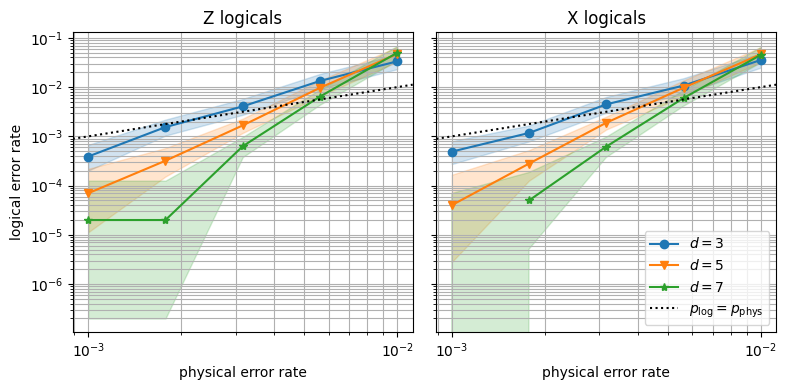

In [8]:
codes_to_simulate = [codes.SurfaceCode(dist, rotated=True) for dist in (3, 5, 7)]
make_memory_experiment_figures(codes_to_simulate, with_MWPM=True)
plt.show()

### The toric code

The toric code requires a different decoder.  We'll use BP-LSD.  These simulations may take a while.

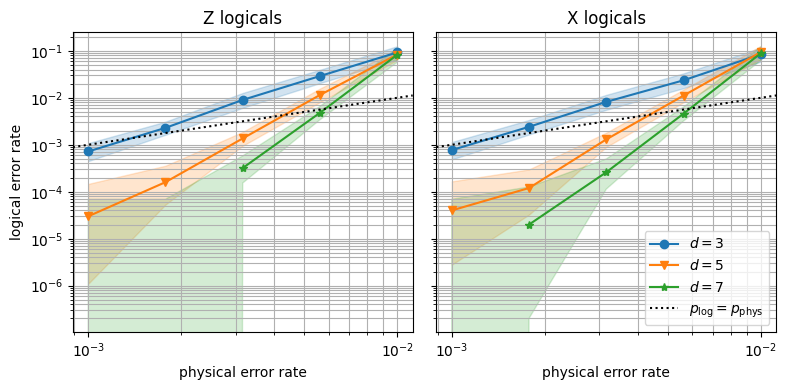

In [9]:
codes_to_simulate = [codes.ToricCode(dist, rotated=False) for dist in (3, 5, 7)]
decoding_kwargs = dict(
    with_BP_LSD=True, max_iter=30, bp_method="ms", lsd_method="lsd_cs", lsd_order=0
)
make_memory_experiment_figures(codes_to_simulate, **decoding_kwargs)
plt.show()

## Combined memory experiments

We can also run simulations that estimate the error rates of _all_ logical observables in one go.  These simulations are "unphysical" because they rely on the use of perfectly noiseless ancilla qubits.  But nothing stops us from instantiating noiseless ancilla qubits in silico!

For CSS codes such as the toric and surface codes, these simulations require us to do a bit of extra work to split simulation data into X and Z sectors that can be decoded independently.  Below, we provide a function to show how all of this works.

### simulation and plotting code

In [10]:
def run_combined_memory_experiments(
    codes_to_simulate: Sequence[codes.QuditCode],
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    **decoding_kwargs: object,
) -> list[sinter.TaskStats]:
    """Use sinter to simulate memory cycles of the given codes.

    This function ...
      1. Builds a memory experiment for each code.
      2. Adds a depolarizing noise to all gates, at the provided error rates.
      2. Wraps each noisy circuit in a `sinter.Task``.
      3. Runs batched Monte Carlo sampling with `sinter.collect`.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probabilities of a depolarizing error after each gate.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        A `sinter` stats object aggregating shots, errors, and metadata for downstream plotting.
    """
    noise_models = {
        prob: circuits.DepolarizingNoiseModel(prob, include_idling_error=False)
        for prob in error_rates
    }

    tasks = []
    custom_decoders = {}  # each code is going to need its own decoder
    for code_index, code in enumerate(codes_to_simulate):
        distance = code.get_distance(bound=distance_trials)

        # Collect the components of the memory experiment.  In particular, we will need the record
        # of detectors and qubit indices.
        initialization, qec_cycle, readout, measurement_record, detector_record, qubit_ids = (
            circuits.get_memory_experiment_parts(code, basis=None, num_rounds=distance)
        )

        # Identify detectors associated with X-type and Z-type stabilizers (parity checks).
        detectors_x = detector_record.get_events(*qubit_ids.checks_x)
        detectors_z = detector_record.get_events(*qubit_ids.checks_z)

        # Build a decoder that separately decodes X and Z sectors to predict X and Z observables.
        # Here X observables are numbered 0, 1, ..., code.dimension - 1, and Z observables are
        # numbered code.dimension, code.dimension + 1, ..., code.dimension * 2 - 1.
        decoder = decoders.SubgraphDecoder(
            (detectors_x, detectors_z),  # X/Z detectors
            (range(code.dimension), range(code.dimension, 2 * code.dimension)),  # X/Z observables
            **decoding_kwargs,
        )
        decoder_name = f"decoder_{code_index}"
        custom_decoders[decoder_name] = decoder

        for prob in error_rates:
            noise_model = noise_models[prob]
            noisy_circuit = initialization + noise_model.noisy_circuit(qec_cycle) + readout
            tasks.append(
                sinter.Task(
                    circuit=noisy_circuit,
                    decoder=decoder_name,
                    json_metadata={"label": get_label(code), "prob": prob},
                )
            )

    return sinter.collect(
        num_workers=os.cpu_count() - 2,
        max_shots=max_shots,
        max_errors=max_errors,
        tasks=tasks,
        custom_decoders=custom_decoders,
    )


def make_combined_memory_experiment_figure(
    codes_to_simulate: Sequence[codes.QuditCode],
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    figsize: tuple[int, int] = (5, 4),
    **decoding_kwargs: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Use sinter to simulate memory cycles of the given codes, and plot the results.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probabilities of a depolarizing error after each gate.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        figsize: The size of the figure to produce.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        The matplotlib.pyplot figure and axis.
    """
    stats = run_combined_memory_experiments(
        codes_to_simulate, error_rates, max_shots, max_errors, distance_trials, **decoding_kwargs
    )

    figure, axis = plt.subplots(figsize=figsize)
    sinter.plot_error_rate(
        ax=axis,
        stats=stats,
        x_func=lambda stats: stats.json_metadata["prob"],
        group_func=lambda stats: stats.json_metadata["label"],
    )

    axis.axline(
        (0, 0),
        slope=1,
        color="k",
        linestyle=":",
        label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$",
    )
    axis.loglog()
    axis.set_xlabel(r"physical error rate")
    axis.set_ylabel(r"logical error rate")
    axis.legend(loc="best")
    axis.grid(which="both")
    figure.tight_layout()

    return figure, axis

### The surface code

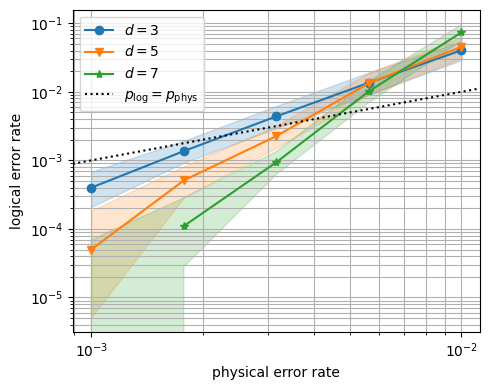

In [11]:
codes_to_simulate = [codes.SurfaceCode(dist, rotated=True) for dist in (3, 5, 7)]
make_combined_memory_experiment_figure(codes_to_simulate, with_MWPM=True)
plt.show()

### The toric code

Again, this may take a while.

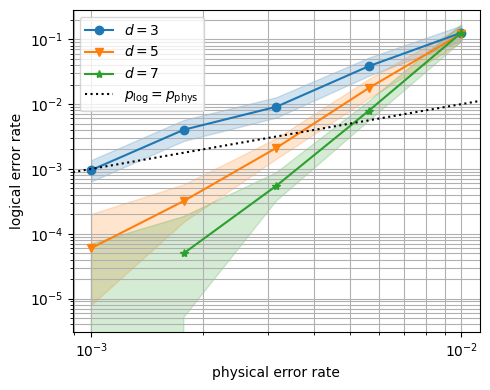

In [12]:
codes_to_simulate = [codes.ToricCode(dist, rotated=False) for dist in (3, 5, 7)]
decoding_kwargs = dict(
    with_BP_LSD=True, max_iter=30, bp_method="ms", lsd_method="lsd_cs", lsd_order=0
)
make_combined_memory_experiment_figure(codes_to_simulate, **decoding_kwargs)
plt.show()

### Bivariate bicycle codes

`BBCode`s come equipped with custom syndrome measurement circuits (inherited from the parent class, `QCCode`) that generalize the circuit for three-term `BBCode`s in Figure 5 of [arXiv:2308.07915v2](https://arxiv.org/abs/2308.07915v2).  Naturally, these simulations may take some time to run, though they could perhaps be sped up with a careful choice of decoder.

Note that numerical results here may differ slightly from those in [arXiv:2308.07915v2](https://arxiv.org/abs/2308.07915v2).  These differences can be attributed to (a) a different choice of decoder, and (b) that the results below account for the error rates of all logical operators, as opposed to only those of a fixed (X or Z) type.

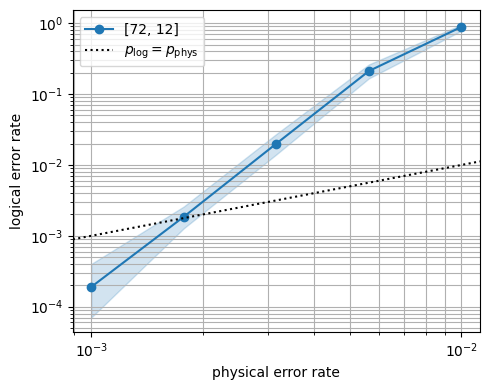

In [13]:
codes_to_simulate = [
    codes.BBCode(
        {x: 6, y: 6},
        x**3 + y + y**2,
        y**3 + x + x**2,
    ),
]
decoding_kwargs = dict(
    with_BP_LSD=True, max_iter=30, bp_method="ms", lsd_method="lsd_cs", lsd_order=0
)
make_combined_memory_experiment_figure(codes_to_simulate, **decoding_kwargs)
plt.show()

## Sliding Window Decoding

We can also make use of `decoders.SlidingWindowDecoder` to split a memory experiment into a sequence of decoding windows.  Here we give an example of using this for X and Z sliding window decoding of a surface code memory experiment. 

### simulation and plotting code

In [14]:
def run_combined_memory_experiments_with_sliding_window_decoder(
    codes_to_simulate: Sequence[codes.QuditCode],
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    num_windows: int = 5,
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    **decoding_kwargs: object,
) -> list[sinter.TaskStats]:
    """Use sinter to simulate memory cycles of the given codes and decoding using a sliding window decoder.

    This function ...
      1. Builds a memory experiment for each code.
      2. Adds a depolarizing noise to all gates, at the provided error rates.
      2. Wraps each noisy circuit in a `sinter.Task``.
      3. Runs batched Monte Carlo sampling with `sinter.collect`.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probabilities of a depolarizing error after each gate.
        num_windows: Number of windows in circuits. The number of rounds in each window is the code distance.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        A `sinter` stats object aggregating shots, errors, and metadata for downstream plotting.
    """
    noise_models = {
        prob: circuits.DepolarizingNoiseModel(prob, include_idling_error=False)
        for prob in error_rates
    }

    tasks = []
    custom_decoders = {}  # each code is going to need its own decoder
    for code_index, code in enumerate(codes_to_simulate):
        distance = code.get_distance(bound=distance_trials)

        # Collect the components of the memory experiment.  In particular, we will need the record
        # of detectors and qubit indices.
        initialization, qec_cycle, readout, measurement_record, detector_record, qubit_ids = (
            circuits.get_memory_experiment_parts(
                code, basis=None, num_rounds=num_windows * distance
            )
        )

        # Identify detectors associated with X-type and Z-type stabilizers (parity checks).
        detectors_x = detector_record.get_events(*qubit_ids.checks_x)
        detectors_z = detector_record.get_events(*qubit_ids.checks_z)

        # Build a sliding window decoder for both X and Z decoding problems
        # The window size is chosen to be the code distance, and the stride is chosen to be half the distance
        # This also corresponds to a commit region of size half the distance.
        decoder = decoders.SlidingWindowDecoder(
            distance,
            distance // 2,
            (detectors_x, detectors_z),  # decode X/Z detectors independently
            **decoding_kwargs,
        )
        decoder_name = f"decoder_{code_index}"
        custom_decoders[decoder_name] = decoder

        for prob in error_rates:
            noise_model = noise_models[prob]
            noisy_circuit = initialization + noise_model.noisy_circuit(qec_cycle) + readout
            tasks.append(
                sinter.Task(
                    circuit=noisy_circuit,
                    decoder=decoder_name,
                    json_metadata={
                        "label": get_label(code),
                        "prob": prob,
                        "rounds": num_windows * distance,
                    },
                )
            )

    return sinter.collect(
        num_workers=os.cpu_count() - 2,
        max_shots=max_shots,
        max_errors=max_errors,
        tasks=tasks,
        custom_decoders=custom_decoders,
    )


def make_sliding_window_memory_experiment_figure(
    codes_to_simulate: Sequence[codes.QuditCode],
    error_rates: Sequence[float] = list(np.logspace(-3, -2, 5)),
    num_windows: int = 5,
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    figsize: tuple[int, int] = (5, 4),
    **decoding_kwargs: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Use sinter to simulate memory cycles of the given codes, and plot the results.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probabilities of a depolarizing error after each gate.
        max_shots: Stop sampling the circuit after this many shots.
        num_windows: Number of windows in circuits. The number of rounds in each window is the code distance.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        figsize: The size of the figure to produce.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        The matplotlib.pyplot figure and axis.
    """
    stats = run_combined_memory_experiments_with_sliding_window_decoder(
        codes_to_simulate,
        error_rates,
        num_windows,
        max_shots,
        max_errors,
        distance_trials,
        **decoding_kwargs,
    )

    figure, axis = plt.subplots(figsize=figsize)
    sinter.plot_error_rate(
        ax=axis,
        stats=stats,
        x_func=lambda stats: stats.json_metadata["prob"],
        group_func=lambda stats: stats.json_metadata["label"],
        failure_units_per_shot_func=lambda stats: stats.json_metadata["rounds"],
    )

    axis.axline(
        (0, 0),
        slope=1,
        color="k",
        linestyle=":",
        label=r"$p_{\mathrm{log}}=p_{\mathrm{phys}}$",
    )
    axis.loglog()
    axis.set_xlabel(r"Physical error rate")
    axis.set_ylabel(r"Logical error rate per round")
    axis.legend(loc="best")
    axis.grid(which="both")
    figure.tight_layout()

    return figure, axis

### Surface Code

Since our experiment involves a larger number of measurement rounds, we opt to plot the logical error rate per round.

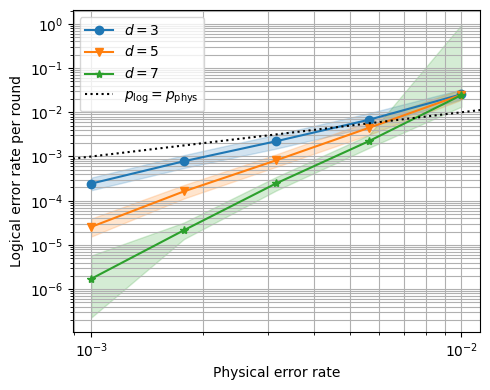

In [15]:
codes_to_simulate = [codes.SurfaceCode(dist, rotated=True) for dist in (3, 5, 7)]
make_sliding_window_memory_experiment_figure(codes_to_simulate, with_MWPM=True)
plt.show()

We can also show the logical error rate per round is constant when using a window of size $d$

### simulation and plotting code

In [16]:
def logical_error_rate_saturation_experiment(
    codes_to_simulate: Sequence[codes.QuditCode],
    error_rate: float = 3e-3,
    num_rounds_list: Sequence[int] = range(1, 25, 2),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    **decoding_kwargs: object,
) -> list[sinter.TaskStats]:
    """Use sinter to simulate logical error rate per round with sliding window decoder for an increasing number of rounds.

    This function ...
      1. Builds a memory experiment for each code.
      2. Adds a depolarizing noise to all gates, at the provided error rate.
      2. Wraps each noisy circuit in a `sinter.Task``.
      3. Runs batched Monte Carlo sampling with `sinter.collect`.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probability of a depolarizing error after each gate.
        num_rounds_list: Sequence of an increasing number of rounds used in experiments.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        A `sinter` stats object aggregating shots, errors, and metadata for downstream plotting.
    """
    noise_model = circuits.DepolarizingNoiseModel(error_rate, include_idling_error=False)

    tasks = []
    custom_decoders = {}  # each code is going to need its own decoder
    for code_index, code in enumerate(codes_to_simulate):
        distance = code.get_distance(bound=distance_trials)

        for num_rounds in num_rounds_list:
            # Collect the components of the memory experiment.  In particular, we will need the record
            # of detectors and qubit indices.
            initialization, qec_cycle, readout, measurement_record, detector_record, qubit_ids = (
                circuits.get_memory_experiment_parts(code, basis=None, num_rounds=num_rounds)
            )

            # Identify detectors associated with X-type and Z-type stabilizers (parity checks).
            detectors_x = detector_record.get_events(*qubit_ids.checks_x)
            detectors_z = detector_record.get_events(*qubit_ids.checks_z)

            # Build a sliding window decoder for both X and Z decoding problems
            # The window size is chosen to be the code distance, and the stride is chosen to be half the distance
            # This also corresponds to a commit region of size half the distance.
            decoder = decoders.SlidingWindowDecoder(
                distance,
                distance // 2,
                (detectors_x, detectors_z),  # decode X/Z detectors independently
                **decoding_kwargs,
            )
            decoder_name = f"decoder_{code_index}_{num_rounds}"
            custom_decoders[decoder_name] = decoder

            noisy_circuit = initialization + noise_model.noisy_circuit(qec_cycle) + readout
            tasks.append(
                sinter.Task(
                    circuit=noisy_circuit,
                    decoder=decoder_name,
                    json_metadata={
                        "label": get_label(code),
                        "prob": error_rate,
                        "rounds": num_rounds,
                    },
                )
            )

    return sinter.collect(
        num_workers=os.cpu_count() - 2,
        max_shots=max_shots,
        max_errors=max_errors,
        tasks=tasks,
        custom_decoders=custom_decoders,
    )


def make_logical_error_rate_saturation_experiment_figure(
    codes_to_simulate: Sequence[codes.QuditCode],
    error_rate: float = 3e-3,
    num_rounds_list: Sequence[int] = list(range(1, 25, 1)),
    max_shots: int = 10**5,
    max_errors: int = 100,
    distance_trials: int = 100,
    figsize: tuple[int, int] = (5, 4),
    **decoding_kwargs: object,
) -> tuple[plt.Figure, plt.Axes]:
    """Use sinter to simulate memory cycles of the given codes, and plot the results.

    Args:
        codes_to_simulate: The codes we wish to simulate.
        error_rates: The i.i.d. probability of a depolarizing error after each gate.
        num_rounds_list: Sequence of an increasing number of rounds used in experiments.
        max_shots: Stop sampling the circuit after this many shots.
        max_errors: Stops the sampling process after this many errors have been seen in samples
            taken from the circuit.
        distance_trials: If the code distance is not known, estimate it with this many trials.
            The estimated distance determines the number of rounds of syndrome measurement.
        figsize: The size of the figure to produce.
        **decoding_kwargs: Arguments to pass to the decoder.

    Returns:
        The matplotlib.pyplot figure and axis.
    """
    stats = logical_error_rate_saturation_experiment(
        codes_to_simulate,
        error_rate,
        num_rounds_list,
        max_shots,
        max_errors,
        distance_trials,
        **decoding_kwargs,
    )

    figsize: tuple[int, int] = (5, 4)
    figure, axis = plt.subplots(figsize=figsize)

    sinter.plot_error_rate(
        ax=axis,
        stats=stats,
        x_func=lambda stats: stats.json_metadata["rounds"],
        group_func=lambda stats: stats.json_metadata["label"],
        failure_units_per_shot_func=lambda stats: stats.json_metadata["rounds"],
    )

    axis.set_yscale("log")
    axis.set_xlabel(r"Number of rounds")
    axis.set_ylabel(r"Logical error rate per round")
    axis.legend(loc="best")
    axis.grid(which="both")
    figure.tight_layout()

    return figure, axis

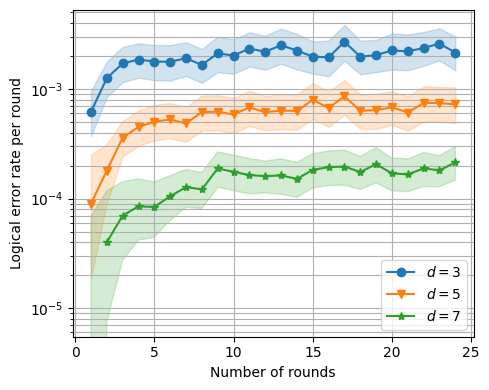

In [17]:
make_logical_error_rate_saturation_experiment_figure(codes_to_simulate, with_MWPM=True)
plt.show()